# Explore Scenario Discovery

In [1]:
##  IMPORT PACKAGES
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging

import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sys
from typing import *

# add the current directoy to the search path and load from here
dir_py = os.path.join(os.getcwd(), "python")
if dir_py not in sys.path:
    sys.path.append(dir_py)


import climate as cl
import predator_prey as pr
import support_functions as sf

/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


##  Computational experiments are often used to generate large datasets, which can be condensed and used for scenario discovery
- Consider the following example

In [2]:
df_exploratory_data = pd.read_csv("/Users/jsyme/Downloads/pt.csv")
df_exploratory_data = (
    df_exploratory_data[
        df_exploratory_data["design_id"].isin([1])
    ]
    .reset_index(drop = True)
)

#

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jsyme/Downloads/pt.csv'

##  Define some cases of interest
- In a vulnerability assessment, cases of interest are those where modeling indicates that the system reaches vulnerable conditions
- There may be different types of vulnerabilities worth assessing
- Let's start with one that is based exclusively on aggregate emissions

In [47]:


field_emission = "emission_co2e_TOTAL_50"
field_vuln_0 = "v0"

# let's define a vulnerability condition; an obvious one is if the actions fail to meet net zero
vec_vuln_0 = [
    int(row[field_emission] > 0) for i, row in df_exploratory_data.iterrows()
]

df_exploratory_data[field_vuln_0] = vec_vuln_0

# fraction of cases that are vulnerable
sum(vec_vuln_0)/df_exploratory_data.shape[0]

0.6838905775075987

(array([  6.,  28.,  46.,  78., 145., 203., 225., 150.,  81.,  25.]),
 array([-2017.        , -1618.24690088, -1219.49380175,  -820.74070263,
         -421.98760351,   -23.23450438,   375.51859474,   774.27169386,
         1173.02479299,  1571.77789211,  1970.53099123]),
 <BarContainer object of 10 artists>)

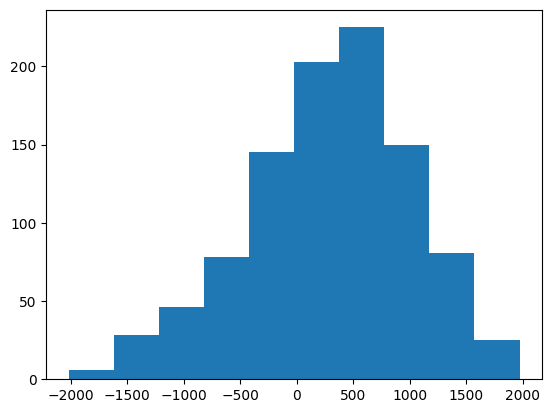

In [32]:
plt.hist(df_exploratory_data[field_emission].to_numpy())

In [31]:

fields_u = [x for x in df_exploratory_data.columns if x.startswith("u")]
fields_x = [x for x in df_exploratory_data.columns if x.startswith("X")]


# Call PRIM, or **P**atient **R**ule **I**nduction **M**ethod
- PRIM is a bump-hunting algorithm that iteratively adds dimensional bounds to create boxes that best capture cases of interest
    - This iteration creates a tradeoff between **Coverage** and **Density**
        - **Coverage**: fraction of all cases of interest explained within the box, or
        
            $C(B) = \frac{|B|}{|X_1|}$,
            
            where $X_1 \subset X$ is the set of all inputs of interest ($X \subset \mathbb{R}^n$) and $B \in \mathbb{R}^m$ is an $m$-dimensional box, $m \leq n$
        
        - **Density**: fraction of all cases in the box that are of interest, or 
        
            $D(B) = \frac{|x_1 \bigcap B|}{|B|}$
- Other algorithms can be used to acheive a similar outcome, such as Random Forest or CART


In [49]:
# get input conditions to search over
arr_x = df_exploratory_data[fields_x]
vec_y = df_exploratory_data[field_vuln_0].to_numpy()

prim_alg = prim.Prim(arr_x, vec_y, threshold = 0.5, peel_alpha=0.1)#, threshold_type = "BELOW")
boxes = prim_alg.find_box()

##  After running, it's useful to inspect what is known as the *Peeling Tracjectory*, which shows the tradeoff between coverage and density
- Genereally speaking, a well-performing dataset will show a concave Pareto frontier:
    - Higher coverage is associated with a lower number of dimensional restrictions
    - Higher density is associated with a higher number of dimensional restrictions
    - Why? How do you choose a box?

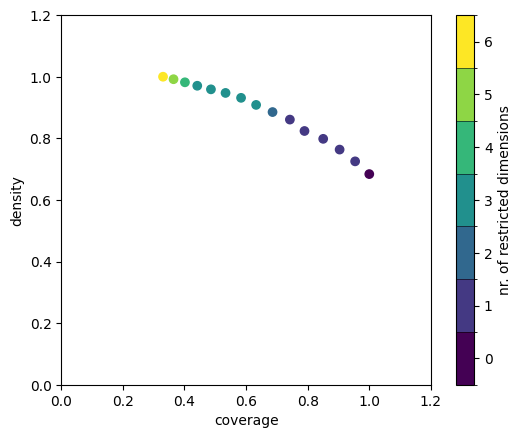

In [55]:
boxes.show_tradeoff()
plt.show()

In [93]:
dir(prim)

['ABOVE',
 'BELOW',
 'CurEntry',
 'DiagKind',
 'EMAError',
 'INFO',
 'NotSeen',
 'PRECISION',
 'PRIMObjectiveFunctions',
 'Prim',
 'PrimBox',
 'PrimException',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 '_logger',
 'alt',
 'calculate_qp',
 'copy',
 'determine_dimres',
 'get_module_logger',
 'get_quantile',
 'is_pareto_efficient',
 'is_significant',
 'itemgetter',
 'itertools',
 'mpl',
 'np',
 'pca_preprocess',
 'pd',
 'plt',
 'rotate_subset',
 'run_constrained_prim',
 'sdutil',
 'setup_prim',
 'sns',
 'temporary_filter',
 'warnings']

##  Scenario Discovery can also be used to inspect conditions that lead to acceptable outcomes
- Consider scenarios where aggregate emissions do not exceed 0.5 GT (a > 90% reduction) AND costs and benefits are at least at the 20th percentile

In [89]:

# some fields
field_emission = "emission_co2e_TOTAL_50"
field_cb = "cb_valueX"
field_accept_0 = "a0"

# get quantiles of net benefits and emissions
vec_cb = df_exploratory_data["cb_valueX"].to_numpy()
dict_qs_cb = dict((f"q{x}", np.quantile(vec_cb, x)) for x in np.arange(11)/10)


# define an acceptability condition instead of a vulnerability to see which components help us meet those conditions
vec_accept_0 = [
    (
        (int(row[field_emission] <= 500) 
         & int(row[field_cb] < dict_qs_cb.get("q0.3")))
    )
    for i, row in df_exploratory_data.iterrows()
]
df_exploratory_data[field_accept_0] = vec_accept_0

# fraction of cases that are acceptable
sum(vec_accept_0)/df_exploratory_data.shape[0]

0.1773049645390071

In [90]:
# get input conditions to search over
arr_x = df_exploratory_data[fields_x]
vec_y = df_exploratory_data[field_accept_0].to_numpy()

prim_alg_accept = prim.Prim(arr_x, vec_y, threshold = 0.5, peel_alpha=0.1)#, threshold_type = "BELOW")
boxes_accept = prim_alg_accept.find_box()

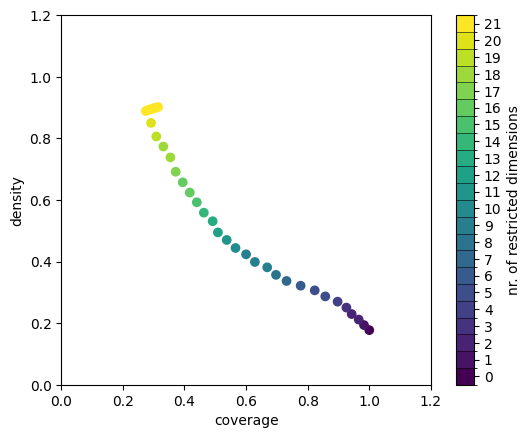

In [91]:
boxes_accept.show_tradeoff()
plt.show()

In [88]:
dir(df[field_cb])

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__column_consortium_standard__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__